In [ ]:
import torch
from io import open
import glob
import os
import re
import numpy as np
import pandas as pd
import math
import copy
import pickle

In [ ]:
data = pd.read_csv("..data/Batch_answers - train_data (no-blank).csv", encoding = "utf-8")
data = data.drop(columns=['Unnamed: 6', 'total no.: 7987'])

In [ ]:
data[['q','r',"q'","r'"]] = data[['q','r',"q'","r'"]].apply(lambda x: x.str.strip('\"'))
data[["q'","r'"]] = data[["q'","r'"]].apply(lambda x: x.str.strip('`'))
data.drop(index=(data.loc[data["q'"]==""].index), inplace=True)
data.drop(index=(data.loc[data["r'"]==""].index), inplace=True)
data.drop_duplicates(keep='last', inplace=True)
data.reset_index(drop=True, inplace=True)
# df.drop(index=(df.loc[(df['table']=='sc')].index))

In [ ]:
len_dic = {}
len_r_dic = {}

for i, line in enumerate(data['q']):
    c = len(data['r'][i].split(' '))
    a = line.split(' ')
    b = len(a)
    if len_dic.get(b) == None:
        len_dic[b] = 1
    else:
        len_dic[b] += 1
    if len_r_dic.get(c) == None:
        len_r_dic[c] = 1
    else:
        len_r_dic[c] += 1

len(len_dic)

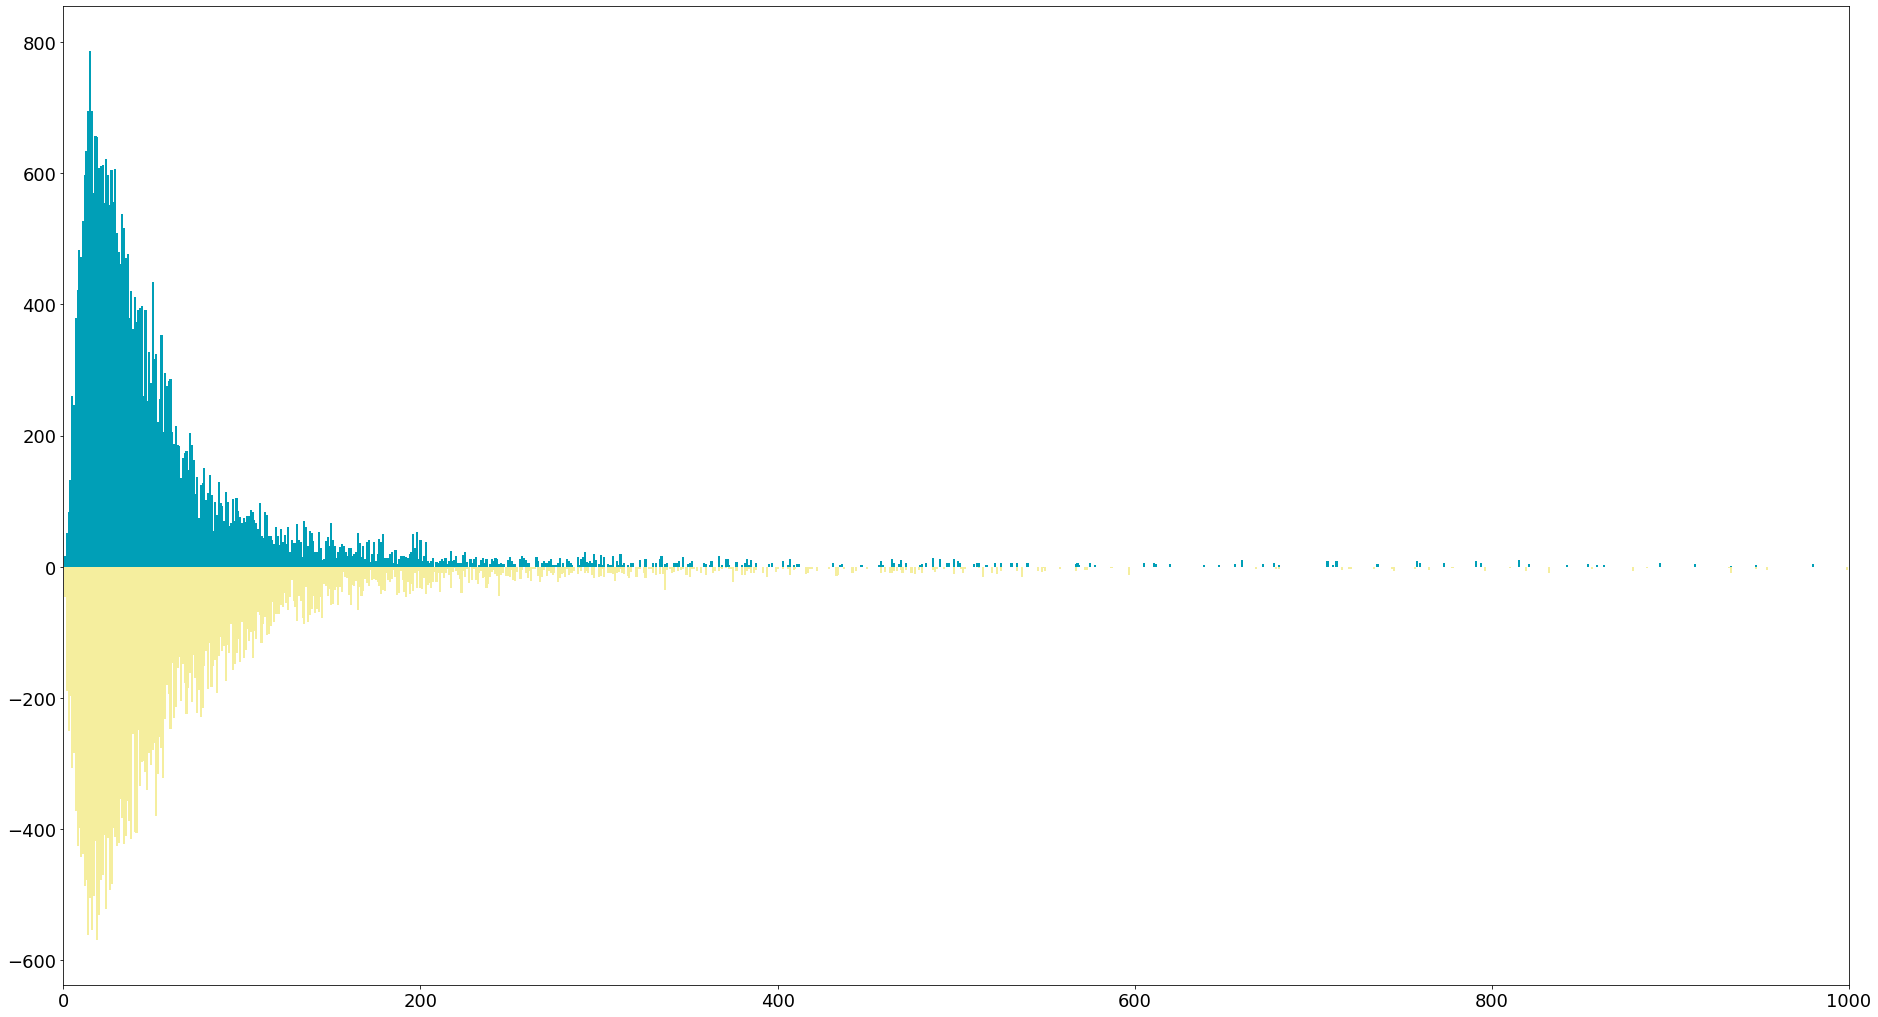

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(32, 18))
plt.bar(list(len_dic.keys()), len_dic.values(), color='#009FB7',width=1.2)
plt.bar(list(len_r_dic.keys()), -np.array([x for x in len_r_dic.values()]), color="#F5EE9E", width=1.2)
# plt.ylim(0, 700)
plt.xlim(0, 1000)

plt.show()
plt.savefig('my_plot.png')

In [ ]:
count = 0
for i, id in enumerate(data['id']):
    if i == len(data['id'])-1:    break
    if id != data['id'][i+1]:
        count += 1
count   #計算重複的計算重複的id

7986

In [ ]:
def get_wordIdx_intervals(idxs: list):
    idxs.sort()
    intervals = []
    # print(idxs)
    if len(idxs) == 0:
        return intervals
    cur, pre = idxs[0], idxs[0]
    for idx in idxs[1:]:
        if cur+1 != idx:    
            intervals.append((pre, cur))
            cur = idx
            pre = idx
            if idx == idxs[-1]:
                intervals.append((pre, cur))
        else:
            cur = idx
            if idx == idxs[-1]:
                intervals.append((pre, cur))
    # print(intervals)
    return intervals

def get_chrIdx_intervals_from_wordIdx_intervals(wordIdx_intervals: list, query: str):
    query_token = query.split(" ")
    chrIdx_intervals = []
    pre_idx = 0
    for (s, e) in wordIdx_intervals:
        sub_q = ' '.join([query_token[i] for i in range(s,e+1)])
        if s == e:
            if s == 0:
                sub_q = sub_q + ' '
                s_idx = query.index(sub_q, pre_idx)
                pre_idx = s_idx + len(sub_q) - 1
            elif s == len(query_token)-1:
                sub_q = ' ' + sub_q
                s_idx = query.index(sub_q, pre_idx) + 1
                pre_idx = s_idx + len(sub_q) - 1
            else:
                sub_q = ' ' + sub_q + ' '
                s_idx = query.index(sub_q, pre_idx) + 1
                pre_idx = s_idx + len(sub_q) - 2
            chrIdx_intervals.append((s_idx , pre_idx-1))
            continue
        s_idx = query.index(sub_q, pre_idx)
        chrIdx_intervals.append((s_idx , s_idx + len(sub_q) - 1))
        pre_idx = s_idx + len(sub_q)
    return chrIdx_intervals

def multi_idx(query, q_):
    q_forward, q_backward = [],[] # forward and backward matched word index
    q_token = q_.split(" ")
    query_token = query.split(" ")

    # forwarding
    source_pointer, target_pointer = 0, 0
    while source_pointer < len(query_token) and target_pointer < len(q_token):
        if query_token[source_pointer] != q_token[target_pointer]:
            source_pointer += 1
        else:
            q_forward.append(source_pointer)
            source_pointer += 1
            target_pointer += 1

    # backwarding
    source_pointer, target_pointer = len(query_token)-1, len(q_token)-1
    while source_pointer >= 0 and target_pointer >= 0:
        if query_token[source_pointer] != q_token[target_pointer]:
            source_pointer -= 1
        else:
            q_backward.append(source_pointer)
            source_pointer -= 1
            target_pointer -= 1
    # get the intervals
    forward_intervals = get_wordIdx_intervals(q_forward)
    backward_intervals = get_wordIdx_intervals(q_backward)
    
    # choose the shorter as the final intervals
    wordIdx_intervals = forward_intervals.copy() if len(forward_intervals) < len(backward_intervals) and  len(forward_intervals) != 0 else backward_intervals.copy()
    if len(backward_intervals) == 0:    wordIdx_intervals = forward_intervals.copy()
    del forward_intervals, backward_intervals
    return get_chrIdx_intervals_from_wordIdx_intervals(wordIdx_intervals, query)


text = "I personly would not condone an abortion , however i would n\'t condem a person who wanted one : its there choice ."
q_ = "would not condone abortion i"
multi_idx(text, q_)

[(11, 27), (32, 39), (51, 51)]

In [ ]:
def get_answer_labels(source:str, target:str):
    if target in source:
        return [(source.index(target), source.index(target)+len(target)-1)]
    else:
        return multi_idx(query=source, q_=target)

In [ ]:
data["q_label"] = data.apply(lambda x : get_answer_labels(x["q"], x["q'"]), axis=1)
data["r_label"] = data.apply(lambda x : get_answer_labels(x["r"], x["r'"]), axis=1)
data.drop(index=(data.loc[data["q_label"].astype(str)=='[]'].index), inplace=True)  #刪掉做完get_answer_labels之後為[]的的row
data.drop(index=(data.loc[data["r_label"].astype(str)=='[]'].index), inplace=True)
data.head(10)

,id,q,r,s,q',r',q_label,r_label
0,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,It can go both ways . We all doubt . It is wha...,True .,"[(0, 76)]","[(0, 5)]"
1,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,can go both ways . We all doubt . It is what y...,True,"[(3, 74)]","[(0, 3)]"
2,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,It can go both ways . We all doubt . It is wha...,True,"[(0, 76)]","[(0, 3)]"
3,9,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,AGREE,seem to support the killing of certain people,based on the idea that people are dispensible ...,"[(17, 61)]","[(0, 92)]"
4,9,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,AGREE,you seem to support the killing of certain peo...,based on the idea that people are dispensible,"[(13, 81)]","[(0, 44)]"
5,9,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,AGREE,support the killing of certain people,can you be against abortion and,"[(25, 61)]","[(297, 327)]"
6,10,"I personly would not condone an abortion , how...","This is a pretty touchy issue , and I agree wi...",AGREE,"not condone an abortion , however i would n't ...",I agree with the different points of view .. m...,"[(17, 113)]","[(36, 153)]"
7,10,"I personly would not condone an abortion , how...","This is a pretty touchy issue , and I agree wi...",AGREE,would not condone abortion i,their body their life its,"[(11, 27), (32, 39), (51, 51)]","[(269, 278), (282, 291), (1155, 1157)]"
8,10,"I personly would not condone an abortion , how...","This is a pretty touchy issue , and I agree wi...",AGREE,"personly would not condone an abortion , howev...","This is a pretty touchy issue , and I agree wi...","[(2, 381)]","[(0, 234)]"
9,10,"I personly would not condone an abortion , how...","This is a pretty touchy issue , and I agree wi...",AGREE,"I personly would not condone an abortion , how...","This is a pretty touchy issue , and I agree wi...","[(0, 92)]","[(0, 76)]"


In [ ]:
def split_sen(data_):    
    for i,(j,z) in enumerate(zip(data_["q"], data_["r"])):
        if len(j.split(" ")) > 200:
            n = math.ceil(len(j.split(" "))/200)
            tmp = j.split(" . ")
            n = math.ceil(len(tmp)/n)
            data_["q"][i] = [(" . ").join(tmp[idx : idx + n]) for idx in range(0, len(tmp), n)]
        else:   data_["q"][i] = [j]
        if len(z.split(" ")) > 200:
            n = math.ceil(len(z.split(" "))/200)
            tmp = z.split(" . ")
            n = math.ceil(len(tmp)/n)
            data_["r"][i] = [(" . ").join(tmp[idx : idx + n]) for idx in range(0, len(tmp), n)]
        else:   data_["r"][i] = [z]
    return data_

In [ ]:
def re_idx(array, label):
    idx_list = np.array([len(x) for x in array])+3
    idx_list_ = np.cumsum(idx_list)
    s_list = idx_list_ - idx_list
    idx_list_ -= 4 
    return [(x, y) for x,y in zip(s_list, idx_list_)]

In [ ]:
def re_pair(q, q_redix):
    return [[a,b] for (a,b) in zip(q, q_redix)]

In [ ]:
def re_label_idx(r_re_idx, r_label):
    s_r , e_r = -1, -1
    for idx, r in enumerate(r_label):
        if (r_re_idx[0] <= r[0] and r[0] <= r_re_idx[1] and r_re_idx[0] <= r[1] and r[1] <= r_re_idx[1]):
            s_r = idx
            break
    for idx, r in reversed(list(enumerate(r_label))):
        if (r_re_idx[0] <= r[0] and r[0] <= r_re_idx[1] and r_re_idx[0] <= r[1] and r[1] <= r_re_idx[1]):
            e_r = idx
            break
    if s_r == -1 and e_r == -1:
        return []
    return r_label[s_r:e_r+1]

# re_label_idx(test2["r_reidx"][12], test2["r_label"][12])

In [ ]:
data = split_sen(data)
data.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-

,id,q,r,s,q',r',q_label,r_label
36010,10001,"[I know one thing , anything that happens , po...",[Was n't sinjin crowing about his plans to tak...,DISAGREE,You are much better off making theft legal and...,"And teen sex does n't , by the very nature of ...","[(111, 227)]","[(0, 57)]"
36011,10002,[I enjoy Botany more than most things and I ha...,"[Hi Smallax , welcome to the forum . I did a s...",DISAGREE,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,"[(0, 108)]","[(0, 76)]"
36012,10002,[I enjoy Botany more than most things and I ha...,"[Hi Smallax , welcome to the forum . I did a s...",DISAGREE,FBI Arrests Three Men in Terror Plot that Targ...,Was n't sinjin crowing about his plans to take...,"[(112, 195)]","[(0, 56)]"
36013,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...","[(0, 106)]","[(0, 119)]"
36014,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,bringing in outside sun light through fiber op...,might give you an idea about costs and concept...,"[(155, 225)]","[(86, 168)]"


In [ ]:
# 這裡要注意，不確定有沒有問題
data["q"][36013] = data["q"][36012]  #  不知道為什麼上面倒數兩排沒有處理到
data["r"][36014] = data["r"][36012]
data["q"][36014] = data["q"][36012]
data["r"][36013] = data["r"][36012]

In [ ]:
data["q_reidx"] = data.apply(lambda x : re_idx(x["q"], x["q_label"]), axis=1)
data["r_reidx"] = data.apply(lambda x : re_idx(x["r"], x["r_label"]), axis=1)
data["q"] = data.apply(lambda x : re_pair(x["q"], x["q_reidx"]), axis=1)
data["r"] = data.apply(lambda x : re_pair(x["r"], x["r_reidx"]), axis=1)
data = data.explode('q').reset_index(drop=True)
data = data.explode('r').reset_index(drop=True)
data["q_reidx"] = data["q"].apply(lambda x : x[1])
data["q"] = data["q"].apply(lambda x : x[0])
data["r_reidx"] = data["r"].apply(lambda x : x[1])
data["r"] = data["r"].apply(lambda x : x[0])
data["q_label"] = data.apply(lambda x : re_label_idx(x["q_reidx"], x["q_label"]), axis=1)
data["r_label"] = data.apply(lambda x : re_label_idx(x["r_reidx"], x["r_label"]), axis=1)
data.drop_duplicates(subset = ['q','r',"q'","r'"],inplace = True)  #!!!!
data.reset_index(drop=True,inplace=True)
data.tail(10)

,id,q,r,s,q',r',q_label,r_label,q_reidx,r_reidx
43052,10001,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,DISAGREE,good thing this argument has never been done !...,"And teen sex does n't , by the very nature of ...","[(0, 107)]","[(0, 124)]","(0, 643)","(0, 260)"
43053,10001,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,DISAGREE,You are much better off making theft legal and...,"And teen sex does n't , by the very nature of ...","[(111, 227)]","[(0, 57)]","(0, 643)","(0, 260)"
43054,10002,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",DISAGREE,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,"[(0, 108)]","[(0, 76)]","(0, 442)","(0, 266)"
43055,10002,I enjoy Botany more than most things and I hav...,https : //www1.fishersci.com/wps/porta ... =y ...,DISAGREE,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,"[(0, 108)]","[(0, 76)]","(0, 442)","(270, 1256)"
43056,10002,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",DISAGREE,FBI Arrests Three Men in Terror Plot that Targ...,Was n't sinjin crowing about his plans to take...,"[(112, 195)]","[(0, 56)]","(0, 442)","(0, 266)"
43057,10002,I enjoy Botany more than most things and I hav...,https : //www1.fishersci.com/wps/porta ... =y ...,DISAGREE,FBI Arrests Three Men in Terror Plot that Targ...,Was n't sinjin crowing about his plans to take...,"[(112, 195)]","[(0, 56)]","(0, 442)","(270, 1256)"
43058,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...","[(0, 106)]","[(0, 119)]","(0, 442)","(0, 266)"
43059,10003,I enjoy Botany more than most things and I hav...,https : //www1.fishersci.com/wps/porta ... =y ...,AGREE,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...","[(0, 106)]","[(0, 119)]","(0, 442)","(270, 1256)"
43060,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,bringing in outside sun light through fiber op...,might give you an idea about costs and concept...,"[(155, 225)]","[(86, 168)]","(0, 442)","(0, 266)"
43061,10003,I enjoy Botany more than most things and I hav...,https : //www1.fishersci.com/wps/porta ... =y ...,AGREE,bringing in outside sun light through fiber op...,might give you an idea about costs and concept...,"[(155, 225)]","[(86, 168)]","(0, 442)","(270, 1256)"


In [ ]:
def fix_label_to_sen(q_label, qs_):
    for idx, (x, z) in enumerate(zip(q_label, qs_)):
        if q_label == []:   return None
        if len(q_label) == 1: return q_label[0]
        # print(qs_)
        if len(qs_) * 1.5 >= q_label[-1][-1] - q_label[0][0] + 1 or q_label[-1][-1] - q_label[0][0] + 1 < 100:
            return (q_label[0][0], q_label[-1][-1])
        else:
            len_ = [j-i+1 for (i, j) in q_label]
            return q_label[len_.index(max(i for i in len_))]

# fix_label_to_sen(data2["r_label"][10],data2["r'"][10])

In [ ]:
data["r_label"] = data.apply(lambda x : fix_label_to_sen(x["r_label"], x["r'"]), axis=1)
data["q_label"] = data.apply(lambda x : fix_label_to_sen(x["q_label"], x["q'"]), axis=1)
data

,id,q,r,s,q',r',q_label,r_label,q_reidx,r_reidx
0,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,It can go both ways . We all doubt . It is wha...,True .,"(0, 76)","(0, 5)","(0, 76)","(0, 5)"
1,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,can go both ways . We all doubt . It is what y...,True,"(3, 74)","(0, 3)","(0, 76)","(0, 5)"
2,8,It can go both ways . We all doubt . It is wha...,True .,AGREE,It can go both ways . We all doubt . It is wha...,True,"(0, 76)","(0, 3)","(0, 76)","(0, 5)"
3,9,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,AGREE,seem to support the killing of certain people,based on the idea that people are dispensible ...,"(17, 61)","(0, 92)","(0, 81)","(0, 337)"
4,9,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,AGREE,you seem to support the killing of certain peo...,based on the idea that people are dispensible,"(13, 81)","(0, 44)","(0, 81)","(0, 337)"
...,...,...,...,...,...,...,...,...,...,...
43051,10002,"I know one thing , anything that happens , pol...",Was n't sinjin crowing about his plans to take...,DISAGREE,FBI Arrests Three Men in Terror Plot that Targ...,Was n't sinjin crowing about his plans to take...,"(112, 195)","(0, 56)","(0, 643)","(0, 260)"
43052,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...","(0, 106)","(0, 119)","(0, 442)","(0, 266)"
43053,10003,I enjoy Botany more than most things and I hav...,https : //www1.fishersci.com/wps/porta ... =y ...,AGREE,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...","(0, 106)",None,"(0, 442)","(270, 1256)"
43054,10003,I enjoy Botany more than most things and I hav...,"Hi Smallax , welcome to the forum . I did a se...",AGREE,bringing in outside sun light through fiber op...,might give you an idea about costs and concept...,"(155, 225)","(86, 168)","(0, 442)","(0, 266)"


In [ ]:
with open("../data/data_fix_label_to_sen_1.5.pkl", "wb") as file:
    pickle.dump(data, file)

with open("../data/data_fix_label_to_sen_1.5.pkl", "rb") as file:
    data = pickle.load(file)